#### Tech Challenge - Fase 2 - Machine Learning and Time Series

#### O problema 

Desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice

#### O que é o índice Ibovespa 

É o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.


https://pt.wikipedia.org/wiki/Ibovespa

https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm

#### Fonte de dados 

Dados históricos do índice IBOVESPA disponíveis publicamente no link https://br.investing.com/indices/bovespa-historical-data e importando para o seguinte repositorio do Github https://github.com/RicardViana/fiap-Machine-Learning-and-Time-Series/blob/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv

#### Dicionário de dados


| Nome da Coluna | Descrição | Tipo de Dado |
| :--- | :--- | :--- |
| `Data` | A data da observação, no formato "DD/MM/AAAA". | Texto (object) |
| `Ultimo` | O preço de fechamento do Ibovespa no dia. | Numérico (float64) |
| `Abertura` | O preço de abertura do Ibovespa no dia. | Numérico (float64) |
| `Maxima` | O preço máximo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Minima` | O preço mínimo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Volume` | O volume de negociações do dia. Os valores são representados em texto com sufixos (ex: "B" para bilhões, "M" para milhões). | Texto (object) |
| `Variacao` | A variação percentual do Ibovespa no dia. | Texto (object) |

#### Objetivo

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:

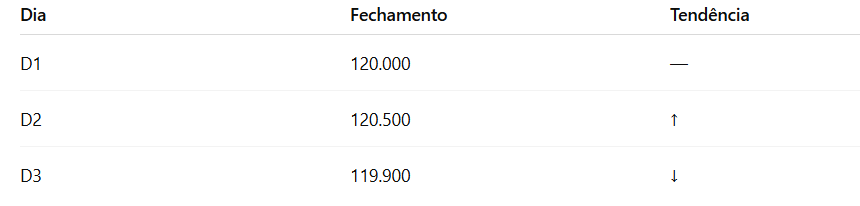

Onde deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste, esse que contera o último mês (30 dias) de dados disponíveis

#### Desenvolvimento

##### Importação de bibliotecas e pacotes

In [985]:
# Importar biblioteca completa
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import calendar
import pandas_ta as ta

# Importar função especifica de um módulo
from statsmodels.tsa.seasonal import seasonal_decompose # --> Geral a decomposição dos dados
from sklearn.preprocessing import StandardScaler
from datetime import date

# Importar função especifica de um módulo --> Modelos de ML
from sklearn.ensemble import RandomForestClassifier # --> Modelo de ML Random Forest
from sklearn.linear_model import LogisticRegression # --> Modelo de ML Regressão Logistica 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Importar função especifica de um módulo --> Metricas para analisar o modelo  
from sklearn.metrics import classification_report

# Outras importações
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

##### Criação de funções (DEF)

##### Análise Exploratória de Dados (EDA)

In [986]:
"""

Com sugestão do colega da pós Tiago Turra existe uma biblioteca chamada yfinance (https://pypi.org/project/yfinance/) que possi os mesmo dados do site https://br.investing.com/indices/bovespa-historical-data

"""

# Importando os dados via yfinance apenas para referencia
# progress --> Não gerar um print do progresso
# auto_adjust --> corrigir o histórico de preços
# multi_level_index --> Utilizando para evitar gerar coluna com o nome do ticket, exemplo ('Close', '^BVSP')

dados_yf = yf.download('^BVSP', period="max", interval="1d", auto_adjust=True,  progress=False, multi_level_index=False)

print("Primeiros dados")
display(dados_yf.head())

print("\nUltimos dados")
display(dados_yf.tail())

Primeiros dados


,Close,High,Low,Open,Volume
Date,,,,,
1993-04-27,24.500000,25.400000,24.500000,24.799999,0
1993-04-28,24.299999,24.600000,23.700001,24.500000,0
1993-04-29,23.700001,24.799999,23.700001,24.299999,0
1993-04-30,24.100000,24.200001,23.700001,23.700001,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,0



Ultimos dados


,Close,High,Low,Open,Volume
Date,,,,,
2025-07-16,135511.0,135641.0,134265.0,135250.0,7833200
2025-07-17,135565.0,135793.0,135016.0,135515.0,6800000
2025-07-18,133382.0,135563.0,133296.0,135563.0,10071800
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100


In [987]:
# Importar os dados via github 
# Necessario o uso do arumento thousands e decimal para não ter problema com o data frame --> o . na fonte é para separar o milhar

link = r"https://raw.githubusercontent.com/RicardViana/fiap-Machine-Learning-and-Time-Series/refs/heads/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv"
dados_origem = pd.read_csv(link, sep= ";", thousands='.', decimal=',', index_col="Data")

In [988]:
# Verificando os dados via .head e .tail

print("Primeiros dados (.head)")
display(dados_origem.head())

print("\nUltimos dados (.tail)")
display(dados_origem.tail())

Primeiros dados (.head)


,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
02/01/1995,4301,4354,4398,4300,"4,10B","-1,22%"
03/01/1995,4098,4370,4386,4094,"8,35B","-4,72%"
04/01/1995,3968,4098,4098,3861,"11,95B","-3,17%"
05/01/1995,4037,3968,4040,3944,"8,76B","1,74%"
06/01/1995,3827,4037,4106,3813,"12,02B","-5,20%"



Ultimos dados (.tail)


,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
30/06/2025,138855,136865,139103,136430,"7,68B","1,45%"
01/07/2025,139549,138855,139695,138855,"6,35B","0,50%"
02/07/2025,139051,139586,140049,138384,"8,81B","-0,36%"
03/07/2025,140928,139051,141304,139051,"6,08B","1,35%"
04/07/2025,141264,140928,141564,140597,"3,31B","0,24%"


In [989]:
# Ajustar o formato da coluna Data 

dados_origem.index = pd.to_datetime(dados_origem.index, format = "%d/%m/%Y")

In [990]:
# Verificand os dados os dados do data frame dados_origem com o dados_yf --> Verificar se há diferença 

print("Dados do data frame dados_origem")
display(dados_origem[['Ultimo', 'Abertura', 'Maxima', 'Minima']].tail())

print("\nDados do data frame dados_yf")
display(dados_yf[['Close', 'Open', 'High', 'Low']].query("Date >= '2025-06-30 00:00:00' and Date <= '2025-07-04 00:00:00'"))


Dados do data frame dados_origem


,Ultimo,Abertura,Maxima,Minima
Data,,,,
2025-06-30,138855,136865,139103,136430
2025-07-01,139549,138855,139695,138855
2025-07-02,139051,139586,140049,138384
2025-07-03,140928,139051,141304,139051
2025-07-04,141264,140928,141564,140597



Dados do data frame dados_yf


,Close,Open,High,Low
Date,,,,
2025-06-30,138855.0,136865.0,139103.0,136430.0
2025-07-01,139549.0,138855.0,139695.0,138855.0
2025-07-02,139051.0,139586.0,140049.0,138384.0
2025-07-03,140928.0,139051.0,141304.0,139051.0
2025-07-04,141478.0,140928.0,141537.0,140597.0


In [991]:
# Veficiando os dados dados do data frame 

dados_origem.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7555 entries, 1995-01-02 to 2025-07-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Ultimo    7555 non-null   int64 
 1   Abertura  7555 non-null   int64 
 2   Maxima    7555 non-null   int64 
 3   Minima    7555 non-null   int64 
 4   Volume    7554 non-null   object
 5   Variacao  7555 non-null   object
dtypes: int64(4), object(2)
memory usage: 413.2+ KB


In [992]:
# Verificando os dados nulos
dados_origem.isnull().sum()

Ultimo      0
Abertura    0
Maxima      0
Minima      0
Volume      1
Variacao    0
dtype: int64

In [993]:
# Verificando os registros que estão nulos 
# Como para o nosso projeto esse campo Volume não é util, vamos manter esse registro
dados_origem[dados_origem.isnull().any(axis=1)]

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
2016-02-10,40377,40592,40592,39960,NaN,"-0,53%"


In [994]:
# Gerando a estatistica descritiva do data frame 

dados_origem.describe()

,Ultimo,Abertura,Maxima,Minima
count,7555.000000,7555.000000,7555.000000,7555.000000
mean,53401.158306,53384.248180,53908.211251,52869.344937
std,38204.901048,38195.050622,38475.116909,37923.170704
min,2138.000000,2138.000000,2449.000000,2110.000000
25%,15098.500000,15094.000000,15275.500000,14858.000000
50%,52230.000000,52210.000000,52836.000000,51585.000000
75%,73438.000000,73435.000000,74463.000000,72493.500000
max,141264.000000,140928.000000,141564.000000,140597.000000


In [995]:
# Verificando o intervalo de data dos dados 

print(f"Data inicial é {dados_origem.index.min()}")
print(f"Data final   é {dados_origem.index.max()}")

Data inicial é 1995-01-02 00:00:00
Data final   é 2025-07-04 00:00:00


In [996]:
# Criando um novo data frame apenas com os campos necessarios

dados_ultimo = dados_origem["Ultimo"].copy()
dados_ultimo.tail()

Data
2025-06-30    138855
2025-07-01    139549
2025-07-02    139051
2025-07-03    140928
2025-07-04    141264
Name: Ultimo, dtype: int64

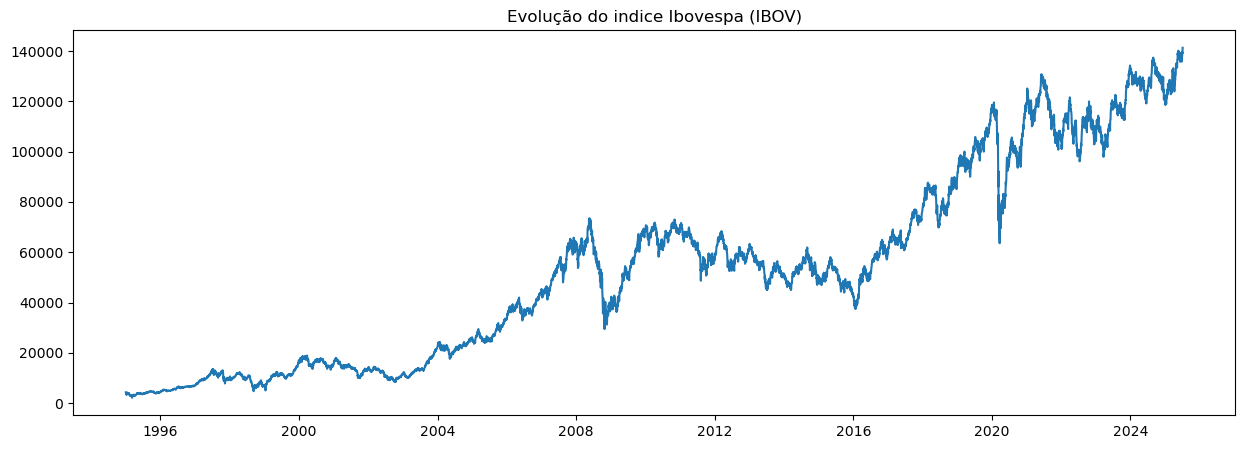

In [997]:
# Plotando um grafico de linha 

plt.figure(figsize=(15,5))
plt.plot(dados_ultimo.index,dados_ultimo)
plt.title("Evolução do indice Ibovespa (IBOV)")
plt.show()

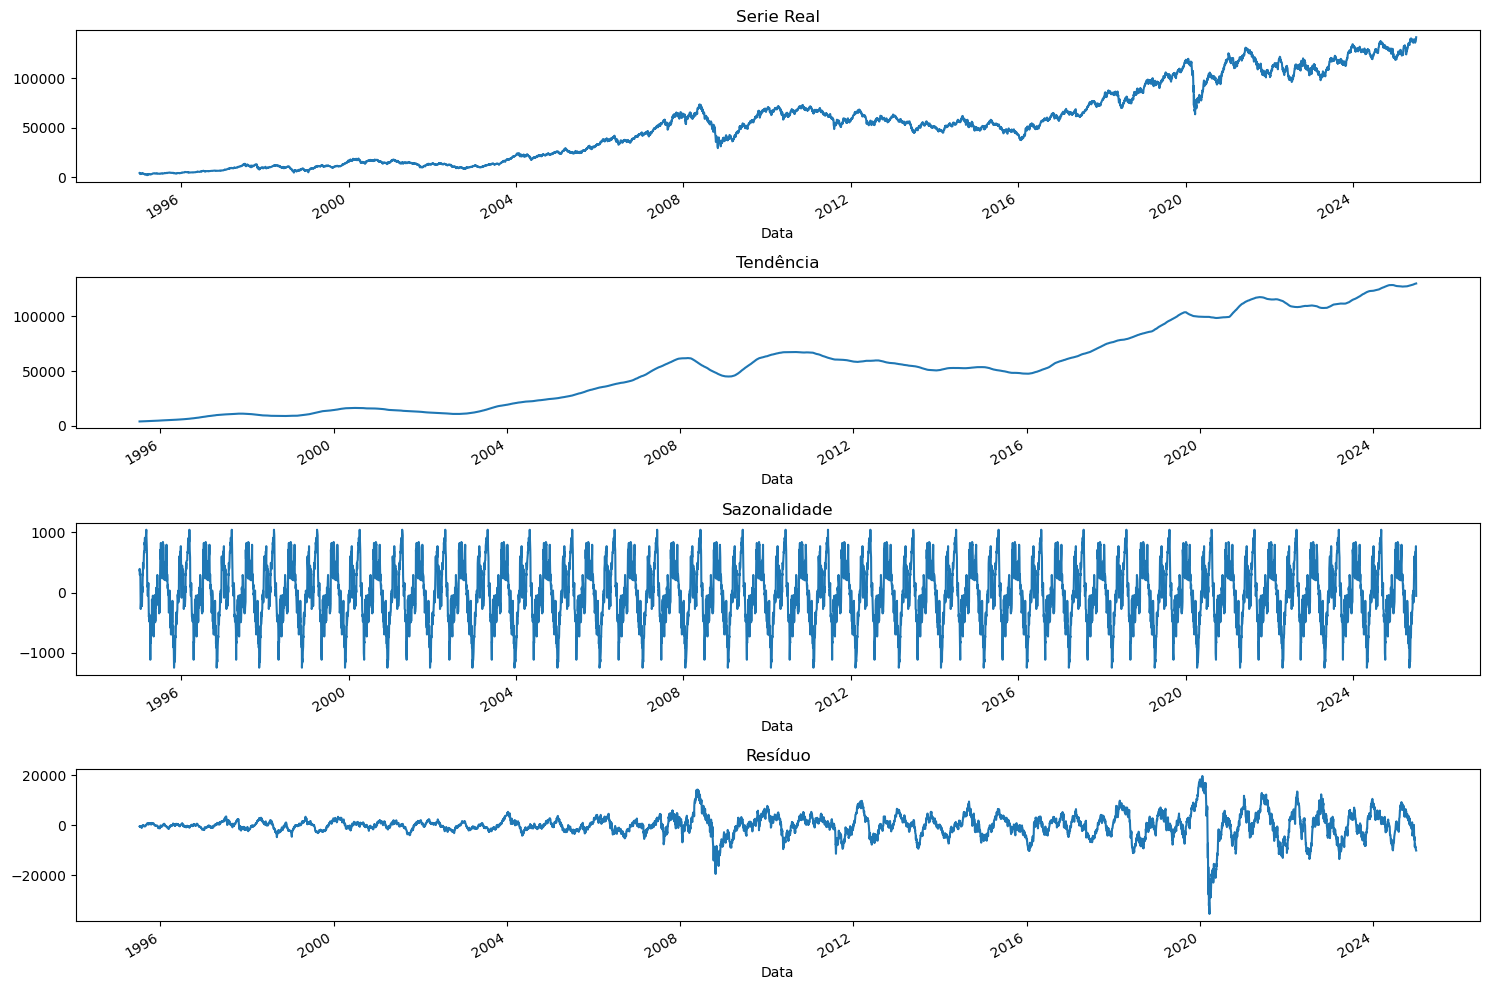

In [998]:
# Realizar a decomposição da seria temporal -->  tendência (trend), sazonalidade (seasonal) e resíduo (resid) e gerar o graficos 

periodo = 252 # Média de dias uteis

resultados = seasonal_decompose(dados_ultimo, period=periodo)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
ax1.set_title("Serie Real")

resultados.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()
plt.show()

##### Feature Engineering

In [999]:
# Criar um novo data frame com os dados originais

dados = dados_origem[["Ultimo", "Abertura", "Maxima", "Minima"]].copy()

In [1000]:
# Alterando o nome das colunas 

dados.index.name = "data"
dados = dados.rename(columns={"Ultimo":"ultimo", "Abertura":"abertura", "Maxima":"maxima", "Minima":"minima"})

In [1001]:
# Ordernando os dados 

dados = dados.sort_index()

In [1002]:
# Criar a variavel Target (Alvo) --> 1 para sobe e 0 para desce 
# Avaliamos o valor atual com o valor do proximo dia e dessa forma conseguimos definir se o dia seguinte subiu (1) ou desceu (0)

#dados['ultimo_amanha'] = dados["ultimo"].shift(-1) # --> Etapa apenas para enteder os calculos e não é necessarios para o modelo
#dados['ultimo_diferenca'] = dados["ultimo"].shift(-1) - dados["ultimo"] # --> Etapa apenas para enteder os calculos e não é necessarios para o modelo

dados['target'] = (dados["ultimo"].shift(-1) > dados["ultimo"]).astype(int)
dados.tail()


,ultimo,abertura,maxima,minima,target
data,,,,,
2025-06-30,138855,136865,139103,136430,1
2025-07-01,139549,138855,139695,138855,0
2025-07-02,139051,139586,140049,138384,1
2025-07-03,140928,139051,141304,139051,1
2025-07-04,141264,140928,141564,140597,0


In [1003]:
# Criar as variações percentuais (lags) --> Comparar percentualmente o dia de hoje com n dias anteriores

qtd_lags = 20

for i in range (1, qtd_lags+1):
    dados[f"lag_{i}"] = dados["ultimo"].pct_change(i)

dados.tail()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
data,,,,,,,,,,,,,,,,,,,,,
2025-06-30,138855,136865,139103,136430,1,0.014532,0.012697,0.022745,0.012321,0.016873,...,0.007656,0.012594,0.017730,0.023257,0.020227,0.019224,0.013525,0.009517,0.015118,0.013340
2025-07-01,139549,138855,139695,138855,0,0.004998,0.019603,0.017759,0.027857,0.017381,...,0.017025,0.012692,0.017655,0.022817,0.028372,0.025327,0.024318,0.018591,0.014562,0.020192
2025-07-02,139051,139586,140049,138384,1,-0.003569,0.001412,0.015965,0.014127,0.024188,...,-0.001472,0.013395,0.009078,0.014023,0.019166,0.024702,0.021668,0.020663,0.014956,0.010942
2025-07-03,140928,139051,141304,139051,1,0.013499,0.009882,0.014929,0.029679,0.027816,...,0.015039,0.012007,0.027075,0.022700,0.027711,0.032924,0.038534,0.035459,0.034440,0.028657
2025-07-04,141264,140928,141564,140597,0,0.002384,0.015915,0.012290,0.017349,0.032134,...,0.018361,0.017459,0.014419,0.029523,0.025138,0.030162,0.035387,0.041010,0.037927,0.036907


In [1004]:
# Criando as médias moveis

dias_medias = [7, 14, 21] 

for dias in dias_medias:
    dados[f"ma_{dias}"] = dados["ultimo"].rolling(window=dias).mean()

dados.tail()

IndentationError: expected an indented block after 'for' statement on line 5 (3008299796.py, line 9)

In [ ]:
# Criando RSI --> Índice de Força Relativa
# Util para medir a velocidade e a magnitude das recentes mudanças do preço de um ativo

janela_ideal = 14

dados["rsi"] = ta.rsi(dados["ultimo"], length=14)
 
dados.tail()

In [ ]:
# Criando o MACD --> Convergência/Divergência de Médias Móveis

# fast = 12
# slow = 26
# signal = 9

# macd = ta.macd(dados["ultimo"], fast = fast, slow = slow, signal = signal)
# dados = pd.concat([dados, macd], axis = 1)

# dados.tail()

In [ ]:
# Criando Bandas de Bollinger

# length = 20

# bollinger = ta.bbands(dados["ultimo"], length = length)
# dados = pd.concat([dados, bollinger], axis = 1)

# dados.tail()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
data,,,,,,,,,,,,,,,,,,,,,
2025-06-30,138855,136865,139103,136430,1,0.014532,0.012697,0.022745,0.012321,0.016873,...,0.007656,0.012594,0.017730,0.023257,0.020227,0.019224,0.013525,0.009517,0.015118,0.013340
2025-07-01,139549,138855,139695,138855,0,0.004998,0.019603,0.017759,0.027857,0.017381,...,0.017025,0.012692,0.017655,0.022817,0.028372,0.025327,0.024318,0.018591,0.014562,0.020192
2025-07-02,139051,139586,140049,138384,1,-0.003569,0.001412,0.015965,0.014127,0.024188,...,-0.001472,0.013395,0.009078,0.014023,0.019166,0.024702,0.021668,0.020663,0.014956,0.010942
2025-07-03,140928,139051,141304,139051,1,0.013499,0.009882,0.014929,0.029679,0.027816,...,0.015039,0.012007,0.027075,0.022700,0.027711,0.032924,0.038534,0.035459,0.034440,0.028657
2025-07-04,141264,140928,141564,140597,0,0.002384,0.015915,0.012290,0.017349,0.032134,...,0.018361,0.017459,0.014419,0.029523,0.025138,0.030162,0.035387,0.041010,0.037927,0.036907


In [ ]:
# Criando Stochastic Oscillator

# stoch = ta.stoch(dados["maxima"], dados["minima"], dados["ultimo"], k=14, d=3)
# dados = pd.concat([dados, stoch], axis=1)

In [ ]:
# Criando Features baseadas na volatilidade do dia 

# dados["amplitude_dia"] = dados["maxima"] - dados["minima"]
# dados["variacao_dia"] = dados["ultimo"] - dados["abertura"]

# dados.tail()

In [ ]:
# Tratar o data frame para evitar o data leakage --> empurrar os dados para a linha de baixo

colunas_excluir = ["target"]
features_a_deslocar = [col for col in dados.columns if col not in colunas_excluir]

dados[features_a_deslocar] = dados[features_a_deslocar].shift(1)

dados.tail()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
data,,,,,,,,,,,,,,,,,,,,,
2025-06-30,136866.0,137113.0,137209.0,136469.0,1,-0.001809,0.008095,-0.002180,0.002307,-0.001823,...,-0.001911,0.003152,0.008600,0.005613,0.004624,-0.000993,-0.004944,0.000578,-0.001175,-0.012040
2025-07-01,138855.0,136865.0,139103.0,136430.0,0,0.014532,0.012697,0.022745,0.012321,0.016873,...,0.007656,0.012594,0.017730,0.023257,0.020227,0.019224,0.013525,0.009517,0.015118,0.013340
2025-07-02,139549.0,138855.0,139695.0,138855.0,1,0.004998,0.019603,0.017759,0.027857,0.017381,...,0.017025,0.012692,0.017655,0.022817,0.028372,0.025327,0.024318,0.018591,0.014562,0.020192
2025-07-03,139051.0,139586.0,140049.0,138384.0,1,-0.003569,0.001412,0.015965,0.014127,0.024188,...,-0.001472,0.013395,0.009078,0.014023,0.019166,0.024702,0.021668,0.020663,0.014956,0.010942
2025-07-04,140928.0,139051.0,141304.0,139051.0,0,0.013499,0.009882,0.014929,0.029679,0.027816,...,0.015039,0.012007,0.027075,0.022700,0.027711,0.032924,0.038534,0.035459,0.034440,0.028657


In [ ]:
# Excluir do data frame os registros vazios

dados = dados.dropna()
dados.head()

,ultimo,abertura,maxima,minima,target,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
data,,,,,,,,,,,,,,,,,,,,,
1995-02-01,3885.0,3581.0,3914.0,3547.0,0,0.084892,0.026691,-0.010695,0.011719,0.033795,...,-0.053363,0.011455,0.110317,0.188073,0.070838,0.015155,-0.037652,-0.020917,-0.051977,-0.096722
1995-02-02,3990.0,3885.0,4067.0,3885.0,1,0.027027,0.114214,0.054440,0.016043,0.039062,...,-0.016272,-0.027778,0.038792,0.140326,0.220183,0.099779,0.042592,-0.011642,0.005544,-0.026354
1995-02-03,3898.0,3990.0,3990.0,3829.0,0,-0.023058,0.003346,0.088523,0.030127,-0.007385,...,-0.074109,-0.038955,-0.050195,0.014840,0.114033,0.192049,0.074421,0.018552,-0.034432,-0.017641
1995-02-06,3944.0,3898.0,3975.0,3837.0,0,0.011801,-0.011529,0.015187,0.101368,0.042283,...,-0.032859,-0.063183,-0.027613,-0.038986,0.026816,0.127179,0.206116,0.087100,0.030572,-0.023037
1995-02-07,3830.0,3944.0,3987.0,3811.0,0,-0.028905,-0.017445,-0.040100,-0.014157,0.069534,...,0.005513,-0.060814,-0.090261,-0.055720,-0.066764,-0.002864,0.094598,0.171254,0.055678,0.000784


##### Criação do modelo de Machine Learning

In [ ]:
# Gerar datas para filtrar treino e teste 

# Definir o ano e mês do intervalo + anos 
ano = 2025
mes = 6
anos = 10

# Gerar as variaveis 
data_inicio_teste = pd.to_datetime(date(ano, mes, 1))
ultimo_dia = calendar.monthrange(ano, mes)[1]
data_fim_teste = pd.to_datetime(date(ano, mes, ultimo_dia))

ano_atual = date.today().year
ano_inicio_treino = ano_atual - anos
data_inicio_treino = pd.to_datetime(date(ano_inicio_treino,1,1))

In [ ]:
# Separar os dados para treino e teste 

x = dados.drop(columns=["abertura", "maxima", "minima","target"])
y = dados["target"]

print("Features (x):")
display(x.tail())

print("\nAlvo (y):")
display(y.tail())

Features (x):


,ultimo,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
data,,,,,,,,,,,,,,,,,,,,,
2025-06-30,136866.0,-0.001809,0.008095,-0.002180,0.002307,-0.001823,-0.013344,-0.014218,-0.017163,-0.002529,...,-0.001911,0.003152,0.008600,0.005613,0.004624,-0.000993,-0.004944,0.000578,-0.001175,-0.012040
2025-07-01,138855.0,0.014532,0.012697,0.022745,0.012321,0.016873,0.012683,0.000995,0.000108,-0.002880,...,0.007656,0.012594,0.017730,0.023257,0.020227,0.019224,0.013525,0.009517,0.015118,0.013340
2025-07-02,139549.0,0.004998,0.019603,0.017759,0.027857,0.017381,0.021955,0.017744,0.005998,0.005107,...,0.017025,0.012692,0.017655,0.022817,0.028372,0.025327,0.024318,0.018591,0.014562,0.020192
2025-07-03,139051.0,-0.003569,0.001412,0.015965,0.014127,0.024188,0.013750,0.018308,0.014112,0.002408,...,-0.001472,0.013395,0.009078,0.014023,0.019166,0.024702,0.021668,0.020663,0.014956,0.010942
2025-07-04,140928.0,0.013499,0.009882,0.014929,0.029679,0.027816,0.038014,0.027434,0.032054,0.027801,...,0.015039,0.012007,0.027075,0.022700,0.027711,0.032924,0.038534,0.035459,0.034440,0.028657



Alvo (y):


data
2025-06-30    1
2025-07-01    0
2025-07-02    1
2025-07-03    1
2025-07-04    0
Name: target, dtype: int32

In [ ]:
# Separar a base em treino e teste

x_train = x[(x.index >= data_inicio_treino) & (x.index < data_inicio_teste)]
y_train = y[(y.index >= data_inicio_treino) & (y.index < data_inicio_teste)]

x_test = x[(x.index >= data_inicio_teste) & (x.index <= data_fim_teste)]
y_test = y[(y.index >= data_inicio_teste) & (y.index <= data_fim_teste)]

In [ ]:
# Normalizar os dados

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# Treinar o modelo e gerar a previsao - Regressao Logistica

modelo_rl = LogisticRegression(random_state=42)
modelo_rl.fit(x_train_scaled,y_train)
previsao_rl = modelo_rl.predict(x_test_scaled)

In [ ]:
# Treinar o modelo e gerar a previsao - Random Forest 

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(x_train_scaled, y_train)
previsao_rf = modelo_rf.predict(x_test_scaled)

In [ ]:
# 1. Criação do modelo base com parâmetros padrão
# Definimos apenas o random_state para garantir a reprodutibilidade dos resultados.
# O restante dos parâmetros será o padrão da biblioteca.
modelo_xgb = XGBClassifier(random_state=42)

# 2. Treinamento do modelo
modelo_xgb.fit(x_train_scaled, y_train)

# 3. Fazendo a previsão
previsao_xgb = modelo_xgb.predict(x_test_scaled)

In [ ]:
# 1. Criação do modelo base com parâmetros padrão
modelo_lgbm = LGBMClassifier(random_state=42, verbose = -1)

# 2. Treinamento do modelo
modelo_lgbm.fit(x_train_scaled, y_train)

# 3. Fazendo a previsão
previsao_lgbm = modelo_lgbm.predict(x_test_scaled)

c:\Users\ricar\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# 1. Criação do modelo base com parâmetros padrão
# Usamos verbose=0 para um output mais limpo.
modelo_cat = CatBoostClassifier(random_state=42, verbose=0)

# 2. Treinamento do modelo
modelo_cat.fit(x_train_scaled, y_train)

# 3. Fazendo a previsão
previsao_cat = modelo_cat.predict(x_test_scaled)

In [ ]:
# Gerar tabela com o score

# Criar um dicionario com os resultados
resultados = [
    ("Regressão Logística", y_test, previsao_rl),
    ("Random Forest", y_test, previsao_rf),
    ("XGBoost", y_test, previsao_xgb),
    ("LightGBM", y_test, previsao_lgbm),
    ("CatBoost", y_test, previsao_cat)
]

# Criar um data frame com os resultados
performance = pd.DataFrame(
    columns=["Modelo", "Acurácia", "Precisão", "Recall", "F1-Score"]
)

for nome_modelo, y_verdadeiro, y_previsto in resultados:
    
    report = classification_report(y_verdadeiro, y_previsto, output_dict=True, zero_division=0)
    
    performance.loc[performance.shape[0]] = {
        "Modelo": nome_modelo,
        "Acurácia": report["accuracy"],
        "Precisão": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }

performance.set_index("Modelo", inplace=True)
performance = performance.map(lambda x: f"{(100 * x):.2f} %")
performance.sort_values(by="Acurácia", ascending=False, inplace=True)

display(performance)

,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
XGBoost,65.00 %,65.36 %,65.00 %,63.60 %
CatBoost,65.00 %,68.12 %,65.00 %,61.51 %
LightGBM,60.00 %,62.35 %,60.00 %,54.29 %
Random Forest,55.00 %,53.06 %,55.00 %,46.11 %
Regressão Logística,45.00 %,46.79 %,45.00 %,42.89 %
